In [27]:
from utilities import *

EPSG_CODE = 2178

In [28]:
dataset_run = database_covers('map_data/temp/')
points_run = parse_gpx_to_points('gpx_data/104_MINUS_2.gpx')
(result_run, elevation_map_run) = get_elevation_for_points(dataset_run, points_run)

In [29]:
len(elevation_map_run)

4067

In [30]:
import matplotlib.pyplot as plt

In [31]:
def cut_to_threshold(data, threshold):
    x = [0]
    y_res = [data[0]]
    temp = 0
    for i in range(1, len(data)):
        temp += data[i] - data[i - 1]
        if temp > threshold or temp < -threshold:
            x.append(i)
            y_res.append(data[i])
            temp = 0

    x.append(len(data) - 1)
    y_res.append(data[-1])

    return x, y_res


In [56]:
ELEVATION_THRESHOLD = 0.25

import numpy as np
# from math import 

def test(SUMOF, SUMHALF, THRESHOLD):
    # def cut_to_threshold(data, threshold):
    #     x = [0]
    #     y_res = [data[0]]
    #     temp = 0
    #     for i in range(1, len(data)):
    #         temp += data[i] - data[i - 1]
    #         if temp > threshold or temp < -threshold:
    #             x.append(i)
    #             y_res.append(data[i])
    #             temp = 0

    #     x.append(len(data) - 1)
    #     y_res.append(data[-1])

    #     return x, y_res

    x_res, y_res = cut_to_threshold(elevation_map_run, THRESHOLD)

    y__ = [0 for i in range(len(elevation_map_run))]

    for i in range(1, len(y_res)):
        y__[x_res[i]] = y_res[i] - y_res[i - 1]

    y__ = np.array(y__)
    y_up = np.cumsum((y__ >= 0) * y__)
    y_down = np.cumsum((y__ <= 0) * y__)

    def find_climbs_descends(diffs):
        climbs, descends = [], []
        last_ele = diffs[0]
        temp = 0
        if last_ele > 0:
            climbs.append(temp)
        else:
            descends.append(temp)
        for i in range(1, len(diffs)):
            if last_ele * diffs[i] < 0:
                # if round(y_up[i - 1] - y_up[temp] - (y_down[i - 1] - y_down[temp]), 2) < ELEVATION_THRESHOLD:
                #     continue
                if last_ele > 0:
                    descends.append(i + SUMHALF)
                else:
                    climbs.append(i + SUMHALF)
                last_ele = diffs[i]
                temp = i

        return climbs, descends


    np_y = np.array(y_res)
    diff = np_y[1:] - np_y[:-1]

    sum25 = [sum(diff[i:i+SUMOF]) for i in range(len(diff) - SUMOF)]
    sum25 = np.array(sum25)

    # print(sum25)
    climbs, descends = find_climbs_descends(sum25)

    data_cutx = np.array(x_res)
    data_cuty = np.array(y_res)

    begin_climb = [data_cutx[i] for i in climbs]
    begin_descend = [data_cutx[i] for i in descends]
    # Descending is first
    # print([x_res[x] for x in climbs])
    if 0 in descends:
        end_descend = [begin_climb[i] - 1 for i in range(len(begin_climb))]
        end_climb = [begin_descend[i] - 1 for i in range(len(begin_descend))][1:]
    else:
        end_climb = [begin_descend[i] - 1 for i in range(len(begin_descend))]
        end_descend = [begin_climb[i] - 1 for i in range(len(begin_climb))][1:]

    if end_descend[-1] > end_climb[-1]:
        end_climb += [len(elevation_map_run) - 1]   
    else:
        end_descend += [len(elevation_map_run) - 1]

    # print(len(begin_climb), len(end_climb), len(begin_descend), len(end_descend))
    ascends = [1 for i in range(len(elevation_map_run))]
    for i in range(len(end_descend)):
        for j in range(begin_descend[i], end_descend[i]):
            # print(j)
            ascends[j] = -1
    return ascends


In [102]:
results = []
for threshold in np.arange(0.2, .4, 0.25):
    for sumof in range(5, 25, 2):
        try:
            res = test(sumof, (sumof + 1) // 2, threshold)
            results.append(res)
        except:
            continue
        

import numpy as np
res_np = np.array(results)

# plt.figure(figsize=(16, 8))
# plt.imshow(res_np, cmap='Greens')
# # plt.colorbar()
# plt.show()

sumarr = np.sum(res_np, axis=0)

ELE_THRESHOLD = 0.5

def find_climbs_descends(diffs):
    climbs, descends = [], []
    last_ele = diffs[0]
    temp = 0
    for i in range(1, len(diffs)):
        if last_ele * diffs[i] < 0:
            if last_ele > 0:
                climbs.append((temp, i - 1))
            elif last_ele < 0:
                descends.append((temp, i - 1))
            last_ele = diffs[i]
            temp = i

    if last_ele < 0:
        descends.append((temp, len(diffs) - 1))
    else:
        climbs.append((temp, len(diffs) - 1))
    return climbs, descends

climbs, descends = find_climbs_descends(sumarr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


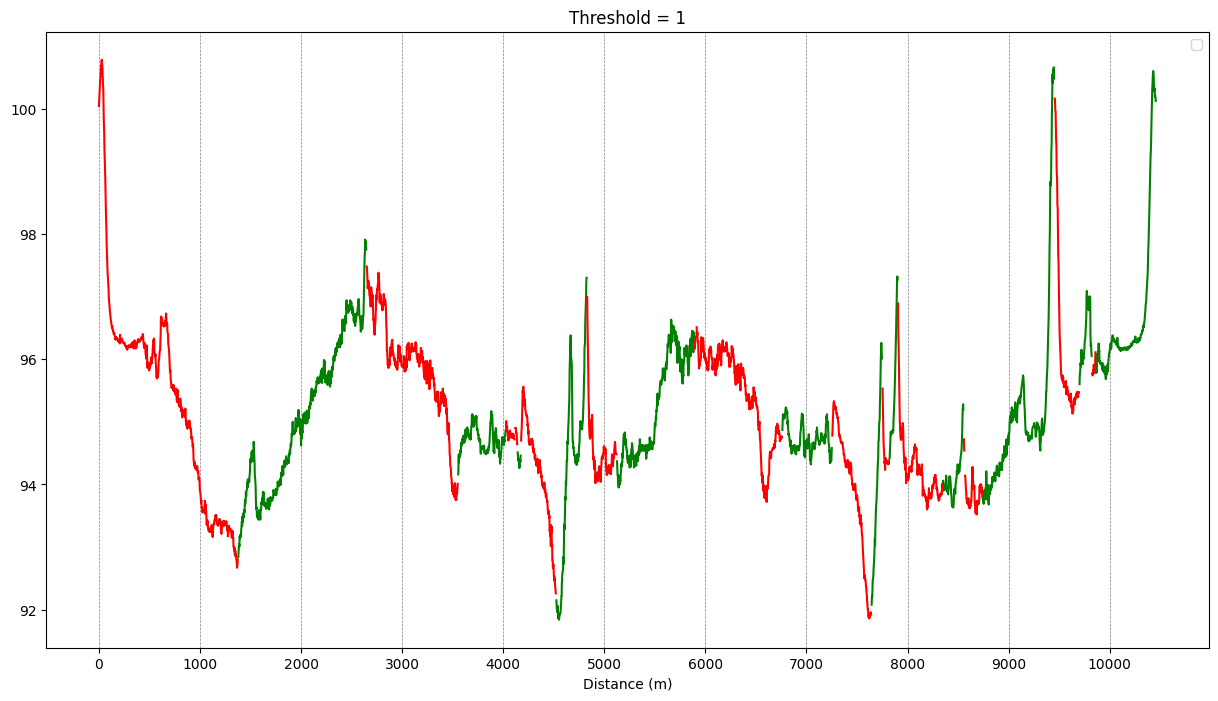

In [103]:
def distance(point1, point2):
    from haversine import haversine
    point1 = (point1[1], point1[0])
    point2 = (point2[1], point2[0])
    return haversine(point1, point2)

def points_to_cumulativedistance(points):
    cumulativedistance = [0]
    for i in range(1, len(points)):
        cumulativedistance.append(cumulativedistance[-1] + distance(points[i - 1][0], points[i][0]))
    return cumulativedistance

cumsum = [int(x * 1000) for x in points_to_cumulativedistance(points_run)]

plt.figure(figsize=(15, 8))
plt.xlabel('Distance (m)')
plt.xticks(range(0, cumsum[-1], 1000))
for i in range(0, cumsum[-1], 1000):
    plt.axvline(i, color='gray', linestyle='--', linewidth=0.5)

# x_res_sum = [cumsum[x] for x in x_res]
for begin_climb, end_climb in climbs:
    plt.plot([cumsum[x] for x in range(begin_climb, end_climb)], elevation_map_run[begin_climb:end_climb], color='green')
    # plt.plot([cumsum[x] for x in [begin_climb[i], end_climb[i]]],  [elevation_map_run[begin_climb[i]], elevation_map_run[end_climb[i]]] , color='green')
    

for begin_descend, end_descend in descends:
    # plt.plot([cumsum[x] for x in [begin_descend[i], end_descend[i]]],  [elevation_map_run[begin_descend[i]], elevation_map_run[end_descend[i]]] , color='red')
    plt.plot([cumsum[x] for x in range(begin_descend, end_descend)], elevation_map_run[begin_descend:end_descend], color='red')

plt.title('Threshold = {THRESHOLD}'.format(THRESHOLD=1))
plt.legend()
plt.show()

In [104]:
x_, y_ = cut_to_threshold(elevation_map_run, 0.25)
y__ = [0 for i in range(len(elevation_map_run))]

for i in range(1, len(y_)):
    y__[x_[i]] = y_[i] - y_[i - 1]

y__ = np.array(y__)
y_up = np.cumsum((y__ >= 0) * y__)
y_down = np.cumsum((y__ <= 0) * y__)

In [105]:
len(y_up)

4067

In [106]:
def uwu(data, asc, desc, threshold):
    x_, y_ = cut_to_threshold(data, threshold)
    y = [0 for i in range(len(data))]
    
    # print(x_)
    # print(y_)
    # print(len(x_), len(y_))
    for i in range(1, len(y_)):
        y[x_[i]] = y_[i] - y_[i - 1]
    
    y = np.array(y)
    y_up = np.cumsum((y >= 0) * y)
    y_down = np.cumsum((y <= 0) * y)

    # print("Ascends:")
    llist = []
    for (a, b) in asc:
        # print("{}-{}: {:.2f}+ {:.2f}-".format(cumsum[a], cumsum[b], y_up[b] - y_up[a], y_down[b] - y_down[a]))
        llist.append((a, b, y_up[b] - y_up[a], y_down[b] - y_down[a], y_up[b] - y_up[a] - (y_down[b] - y_down[a])))

    # print("Descends:")
    for (a, b) in desc:
        # print("{}-{}: {:.2f}+ {:.2f}-".format(cumsum[a], cumsum[b], y_up[b] - y_up[a], y_down[b] - y_down[a]))
        llist.append((a, b, y_up[b] - y_up[a], y_down[b] - y_down[a], y_up[b] - y_up[a] - (y_down[b] - y_down[a])))

    def change(list):
        for i in range(len(list)):
            if list[4] < 0.5:
                pass

    import prettytable
    tb = prettytable.PrettyTable()
    tb.field_names = ["Begin", "End", "Up", "Down", "Total", "Is climb"]
    llist.sort()
    for (a, b, c, d, e) in llist:
        tb.add_row([a, b, round(c, 2), round(-d, 2), round(e, 2), e > 0])
    
    print(tb)

    return llist

llist = uwu(elevation_map_run, climbs, descends, 0.2)


+-------+------+------+------+-------+----------+
| Begin | End  |  Up  | Down | Total | Is climb |
+-------+------+------+------+-------+----------+
|   0   | 499  | 1.98 | 9.28 | 11.26 |   True   |
|  500  | 1009 | 8.64 | 3.47 | 12.11 |   True   |
|  1010 | 1365 | 4.12 | 7.63 | 11.75 |   True   |
|  1366 | 1553 | 2.02 | 1.31 |  3.33 |   True   |
|  1554 | 1589 | 0.0  | 0.24 |  0.24 |   True   |
|  1590 | 1590 | 0.0  | -0.0 |  0.0  |  False   |
|  1591 | 1600 | 0.0  | 0.2  |  0.2  |   True   |
|  1601 | 1614 | 0.0  | 0.26 |  0.26 |   True   |
|  1615 | 1752 | 1.04 | 3.43 |  4.47 |   True   |
|  1753 | 1881 | 7.43 | 2.44 |  9.87 |   True   |
|  1882 | 1994 | 1.16 | 3.67 |  4.83 |   True   |
|  1995 | 2306 | 5.21 | 3.27 |  8.48 |   True   |
|  2307 | 2312 | 0.0  | -0.0 |  0.0  |  False   |
|  2313 | 2313 | 0.0  | -0.0 |  0.0  |  False   |
|  2314 | 2649 | 3.12 | 4.8  |  7.92 |   True   |
|  2650 | 2846 | 1.94 | 2.19 |  4.13 |   True   |
|  2847 | 2993 | 0.46 | 3.35 |  3.81 |   True   |


+-------+------+------+------+-------+----------+
| Begin | End  |  Up  | Down | Total | Is climb |
+-------+------+------+------+-------+----------+
|   0   | 499  | 1.98 | 9.28 | 11.26 |   True   |
|  500  | 1009 | 8.64 | 3.47 | 12.11 |  False   |
|  1010 | 1365 | 4.12 | 7.63 | 11.75 |   True   |
|  1366 | 1614 | 2.02 | 2.01 |  4.03 |  False   |
|  1615 | 1752 | 1.04 | 3.43 |  4.47 |   True   |
|  1753 | 1881 | 7.43 | 2.44 |  9.87 |  False   |
|  1882 | 1994 | 1.16 | 3.67 |  4.83 |   True   |
|  1995 | 2313 | 5.21 | 3.27 |  8.48 |  False   |
|  2314 | 2649 | 3.12 | 4.8  |  7.92 |   True   |
|  2650 | 2846 | 1.94 | 2.19 |  4.13 |   True   |
|  2847 | 2993 | 0.46 | 3.35 |  3.81 |   True   |
|  2994 | 3035 | 4.37 | 0.47 |  4.84 |  False   |
|  3036 | 3061 | 0.0  | 1.3  |  1.3  |   True   |
|  3062 | 3095 | 2.99 | -0.0 |  2.99 |  False   |
|  3096 | 3266 | 1.15 | 4.21 |  5.36 |   True   |
|  3267 | 3348 | 1.95 | 1.02 |  2.97 |  False   |
|  3349 | 3412 | 1.01 | 1.19 |  2.2  |   True   |


/home/istrzalka/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3433: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


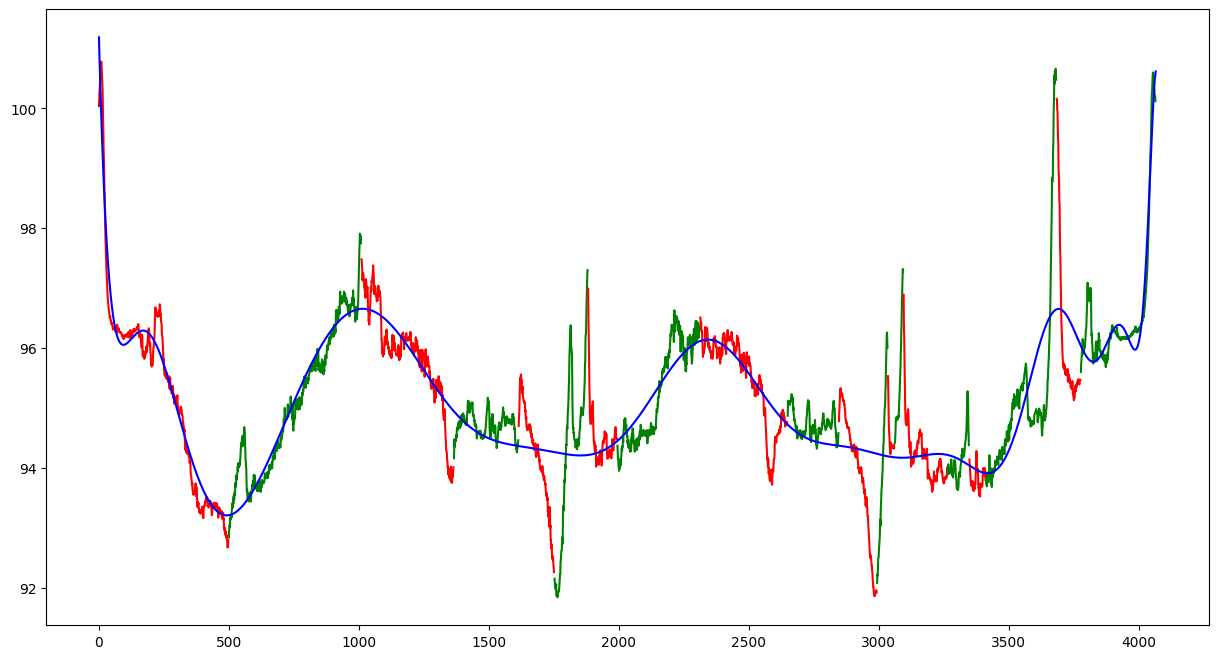

In [110]:
def cut_by(llist, threshold):
    res = []
    for i in range(1, len(llist) - 1):
        if llist[i][4] < threshold:
            begin = llist[i - 1][0]
            end = llist[i + 1][1]
            up = llist[i - 1][2] + llist[i][2] + llist[i + 1][2]
            down = llist[i - 1][3] + llist[i][3] + llist[i + 1][3]
            new_list = llist[:i - 1] + [(begin, end, up, down, up - down)] + llist[i + 2:]
            return cut_by(new_list, threshold)

    return llist


new_list = cut_by(llist, 1)
import prettytable
tb = prettytable.PrettyTable()
tb.field_names = ["Begin", "End", "Up", "Down", "Total", "Is climb"]
llist.sort()
for (a, b, c, d, e) in new_list:
    tb.add_row([a, b, round(c, 2), round(-d, 2), round(e, 2), -d > c])
print(tb)


plt.figure(figsize=(15, 8))

for i in range(len(new_list)):
    color = 'red' if i % 2 == 0 else 'green'
    X = [x for x in range(new_list[i][0], new_list[i][1])]
    Y = [elevation_map_run[x] for x in range(new_list[i][0], new_list[i][1])]
    plt.plot(X, Y, color=color)

p = np.polyfit([x for x in range(len(elevation_map_run))], elevation_map_run, len(new_list) * 2)
y = np.poly1d(p)
plt.plot([x for x in range(len(elevation_map_run))], y([x for x in range(len(elevation_map_run))]), color='blue')
plt.show()  




372 186


/home/istrzalka/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3433: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


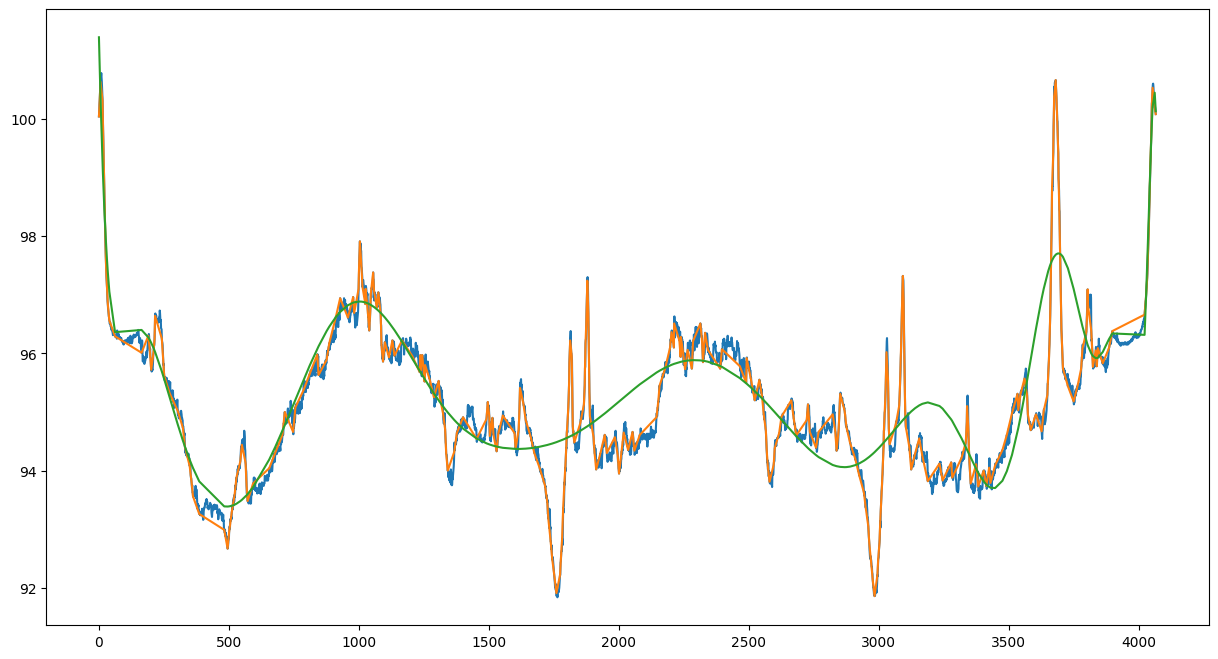

In [122]:
test_x, test_y = cut_to_threshold(elevation_map_run, 0.25)
print(len(test_x), len(test_x) // 2)
poly = np.polyfit(test_x, test_y, len(test_x) // 5)
poly_y = np.poly1d(poly)
plt.figure(figsize=(15, 8))
plt.plot([x for x in range(len(elevation_map_run))], elevation_map_run)
plt.plot(test_x, test_y)
plt.plot(test_x, poly_y(test_x))
plt.show()